In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mne

from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from gait_modulation import MatFileReader, DataProcessor, Visualise, FeatureExtractor
from gait_modulation import BaseModel, RegressionModels, LinearRegressionModel, RegressionLSTMModel
from gait_modulation.utils.utils import split_data_stratified, load_config, create_lagged_data

from tensorflow.keras.callbacks import Callback,  ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau

In [2]:
lfp_metadata_config = load_config('gait_modulation/configs/written/lfp_metadata_config.yaml')

sfreq = lfp_metadata_config['LFP_METADATA']['lfp_sfreq']

In [3]:
time_continuous_uniform = np.load('processed/features/time_continuous_uniform-feat.npz')['times_uniform']
time_continuous_uniform.shape

(16, 6, 38213)

# Linear Regression

In [ ]:
# Parameters for prediction
# future_steps = [1, 10, 100]  # Prediction horizons in samples

horizons_samples = [0, 3, 12, 25]  # Future horizons in samples
horizons_ms = [(samples * 1000 / sfreq) for samples in horizons_samples]
horizons_ms

[0.0]

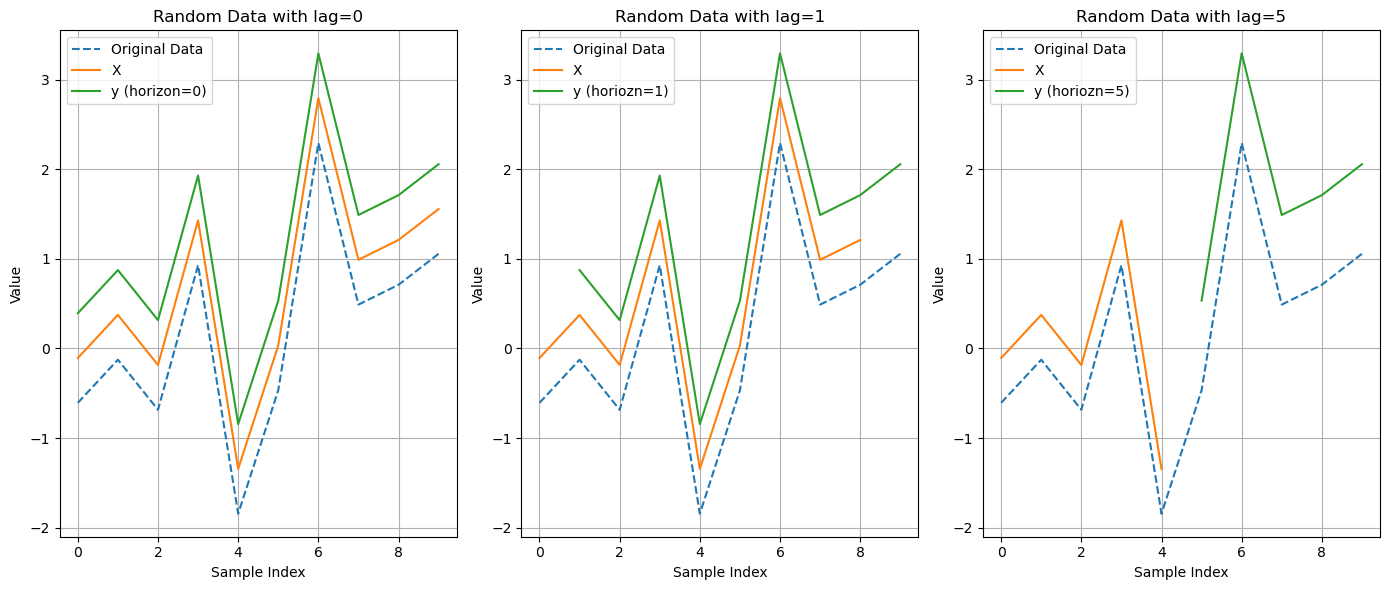

In [5]:
# Illustration of of model prediction with different time lags
# Generate random data

np.random.seed(40)
random_data = np.random.randn(10)
dt = [0, 1, 5]

fig, axs = plt.subplots(1, 3, figsize=(14, 6))

for i, d in enumerate(dt):
    axs[i].plot(random_data, '--', label="Original Data")
    if d == 0:
        axs[i].plot(np.arange(0, len(random_data)), random_data+0.5, label="X")
        axs[i].plot(np.arange(d, len(random_data)), random_data+1, label=f"y (horizon={d})")
    else:
        axs[i].plot(np.arange(0, len(random_data)-d), random_data[:-d]+0.5, label="X")
        axs[i].plot(np.arange(d, len(random_data)), random_data[d:]+1, label=f"y (horiozn={d})")
    axs[i].set_title(f"Random Data with lag={d}")
    axs[i].set_xlabel("Sample Index")
    axs[i].set_ylabel("Value")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


# KFold

In [6]:
config_path_linear = 'gait_modulation/configs/linearRegression_config.yaml'
config_path_lstm = 'gait_modulation/configs/regression_lstm_config.yaml'

# Define a set of models to evaluate
models = {
    "linear_regression": LinearRegressionModel(config_path_linear, model_type='linear'),
    # "ridge_regression": LinearRegressionModel(config_path_linear, model_type='ridge'),
    # "lasso_regression": LinearRegressionModel(config_path_linear, model_type='lasso'),
    "lstm_regression": RegressionLSTMModel(config_path_lstm),
}

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-12-19 02:53:06.090704: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-19 02:53:06.091071: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:

class CustomProgressLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # logs = logs or {}
        # print(f"Epoch {epoch + 1}/{self.params['epochs']}")
        # print(f"\n---------------------------- Epoch {epoch+1} ----------------------------\n")
        pass
    
    def on_batch_end(self, batch, logs=None):
        # logs = logs or {}
        # loss = logs.get('loss', 0.0)
        # accuracy = logs.get('accuracy', 0.0)
        # print(f"Batch {batch + 1}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
        pass
    
# Define the callbacks
tensorboard_callback = TensorBoard(log_dir='regression_logs/fit', histogram_freq=0)  # Set to 0 to disable histogram logging

checkpoint_callback = ModelCheckpoint(
    filepath='regression_LSTM_best_model.h5', 
    monitor='loss', 
    save_best_only=True
)

callbacks = [
    # CustomProgressLogger(),
    # checkpoint_callback,
    # tensorboard_callback,
    # EarlyStopping(monitor='loss', patience=2, restore_best_weights=True),
    # ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1, min_lr=1e-5)
]

## KFold

In [ ]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)  # Number of splits (folds)

predictions_kf = {}
folds_avg_metrics_kf = {}

for horizon in horizons_samples:
    print("\n###########################################################################\n")
    print(f"### Predicting {horizon} samples ({horizon / sfreq * 1000} ms) into the future ###\n")
    predictions_kf[horizon] = {}
    folds_avg_metrics_kf[horizon] = {}

    for model_name, model in models.items():
        print(f"### Training {model_name} model ###\n")

        # Reshape the data as per model requirements
        if model_name == 'lstm_regression':
            reshaped_flat_time = time_continuous_uniform.transpose(0, 2, 1)[:, 0:1000, :]
        else:
            reshaped_flat_time = FeatureExtractor.reshape_lfp_data(
                time_continuous_uniform, mode="flat_time")

        X, y = create_lagged_data(reshaped_flat_time, horizon)

        folds_metrics = {metric.name: [] for metric in model.metrics}  # Initialize a dictionary to store metric values
        predictions_kf[horizon][model_name] = {}

        for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
            print(f"\n### Fold {fold} ###")

            # Split data into training and test sets
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Train the model
            if model.model_type == 'lstm':
                print(f"Training {model_name} on fold {fold}...")
                model.fit(X_train, y_train, callbacks)
            else:
                model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)
            print(f"Fold: {fold} | y_test shape: {y_test.shape}, y_pred shape: {y_pred.shape}")

            evaluation_results = model.evaluate(y_test, y_pred)

            # Store the results for each fold
            predictions_kf[horizon][model_name][fold] = {
                'y_test': y_test,
                'y_pred': y_pred,
                **evaluation_results,  # Unpack the evaluation results directly
                'manual_mse': np.mean((y_test - y_pred) ** 2)
            }

            # Store each metric result
            for metric in model.metrics:
                metric_name = metric.name
                folds_metrics[metric_name].append(evaluation_results.get(metric_name))

            # Log evaluation results for the current fold
            metrics_string = ", ".join([
                f"{metric.name.upper()}: {evaluation_results.get(metric.name):.4f}" for metric in model.metrics
            ])
            
            # for metric in model.metrics:
            #     metric.reset_state()
                
            print(f"{model_name} - Fold {fold} | {metrics_string}")

        # After finishing all folds, calculate the average and std for each metric
        folds_avg_metrics_kf[horizon][model_name] = {}
        for metric_name, values in folds_metrics.items():
            avg_metric = np.mean(values)
            std_metric = np.std(values)
            folds_avg_metrics_kf[horizon][model_name][metric_name] = {'avg': avg_metric, 'std': std_metric}

            # Print the average and std for each metric
            print(f"{model_name} - {metric_name.upper()} - Avg: {avg_metric:.4f}, Std: {std_metric:.4f}")

        # Add a separator to indicate the end of the current model's evaluation
        print("\n--------------------------------------------")

    print("\n###########################################################################\n")


###########################################################################

### Predicting 0 samples (0.0 ms) into the future ###

### Training linear_regression model ###


### Fold 1 ###
Fold: 1 | y_test shape: (203803, 6), y_pred shape: (203803, 6)
linear_regression - Fold 1 | MY_MSE: 0.4511, MY_MAE: 0.4826, R2_SCORE: 0.9900

### Fold 2 ###
Fold: 2 | y_test shape: (203803, 6), y_pred shape: (203803, 6)
linear_regression - Fold 2 | MY_MSE: 0.4447, MY_MAE: 0.4828, R2_SCORE: 0.9900

### Fold 3 ###
Fold: 3 | y_test shape: (203802, 6), y_pred shape: (203802, 6)
linear_regression - Fold 3 | MY_MSE: 0.5664, MY_MAE: 0.4838, R2_SCORE: 0.9900
linear_regression - MY_MSE - Avg: 0.4874, Std: 0.0559
linear_regression - MY_MAE - Avg: 0.4830, Std: 0.0005
linear_regression - R2_SCORE - Avg: 0.9900, Std: 0.0000

--------------------------------------------
### Training lstm_regression model ###


### Fold 1 ###
Training lstm_regression on fold 1...
Using batch size: 10, steps per epoch: 1
Training 

2024-12-19 02:53:09.013496: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 19883s 19883s/step - loss: 1.0462 - my_mse: 1.0462 - my_mae: 0.7197 - r2_score: -0.0462
Epoch 2/5
Batch 0: X shape = (10, 1000, 6), y shape = (10, 1000, 6)
1/1 [==============================] - 1s 872ms/step - loss: 1.0112 - my_mse: 1.0112 - my_mae: 0.7065 - r2_score: -0.0112
Epoch 3/5
Batch 0: X shape = (10, 1000, 6), y shape = (10, 1000, 6)
1/1 [==============================] - 1s 655ms/step - loss: 0.9835 - my_mse: 0.9835 - my_mae: 0.6947 - r2_score: 0.0165
Epoch 4/5
Batch 0: X shape = (10, 1000, 6), y shape = (10, 1000, 6)
1/1 [==============================] - 1s 643ms/step - loss: 0.9625 - my_mse: 0.9625 - my_mae: 0.6839 - r2_score: 0.0375
Epoch 5/5
Batch 0: X shape = (10, 1000, 6), y shape = (10, 1000, 6)
1/1 [==============================] - 949s 949s/step
Fold: 1 | y_test shape: (6, 1000, 6), y_pred shape: (6, 1000, 6)
lstm_regression - Fold 1 | MY_MSE: 112.5544, MY_MAE: 7.3059, R2_SCORE: -0.0154

### Fold 2 ###
Training lstm_regressio

In [ ]:

h = 0
selected_moodel = 'lstm_regression'

print(f"Model: {selected_moodel} - Horizon: {horizons_samples[h]} samples ({horizons_ms[h]} ms)")
for i in range(1, 4):
    t = predictions_kf[horizons_samples[h]][selected_moodel][i]['y_test']
    p = predictions_kf[horizons_samples[h]][selected_moodel][i]['y_pred']

    print(t.shape, p.shape)
    
    print(predictions_kf[horizons_samples[h]][selected_moodel][i]['mae'])
    # print(predictions_kf[horizons_samples[h]][selected_moodel][i]['manual_mse'])
    print(np.mean(np.abs(t - p)))
    
    print("-------"*10)
    
predictions_kf[horizons_samples[h]][selected_moodel][i].keys()
    

Model: lstm_regression - Horizon: 0 samples (0.0 ms)
(6, 1000, 6) (6, 1000, 6)
7.3058577
7.305857836972458
----------------------------------------------------------------------
(5, 1000, 6) (5, 1000, 6)
10.6786785
10.678678810134608
----------------------------------------------------------------------
(5, 1000, 6) (5, 1000, 6)
7.8735385
7.873539048546546
----------------------------------------------------------------------


dict_keys(['y_test', 'y_pred', 'my_mse', 'my_mae', 'r2_score', 'manual_mse'])

## TimeSeriesSplit

In [10]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

predictions_tscv = {}
folds_avg_metrics_tscv = {}

for horizon in horizons_samples:
    print("\n###########################################################################\n")
    print(f"### Predicting {horizon} samples ({horizon / sfreq * 1000} ms) into the future ###\n")
    predictions_tscv[horizon] = {}
    folds_avg_metrics_tscv[horizon] = {}

    for model_name, model in models.items():
        print(f"### Training {model_name} model ###\n")

        # Reshape the data as per model requirements
        if model_name == 'lstm_regression':
            reshaped_flat_time = time_continuous_uniform.transpose(0, 2, 1)[:, 0:1000, :]
        else:
            reshaped_flat_time = FeatureExtractor.reshape_lfp_data(
                time_continuous_uniform, mode="flat_time")

        X, y = create_lagged_data(reshaped_flat_time, horizon)

        folds_metrics = {metric.name: [] for metric in model.metrics}  # Initialize a dictionary to store metric values
        predictions_tscv[horizon][model_name] = {}

        for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
            print(f"\n### Fold {fold} ###")

            # Split data into training and test sets
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Train the model
            if model.model_type == 'lstm':
                print(f"Training {model_name} on fold {fold}...")
                model.fit(X_train, y_train, callbacks)
            else:
                model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)
            
            print(f"Fold: {fold} | y_pred shape: {y_pred.shape}, y_test shape: {y_test.shape}")
            evaluation_results = model.evaluate(y_test, y_pred)

            # Store the results for each fold
            predictions_tscv[horizon][model_name][fold] = {
                'y_test': y_test,
                'y_pred': y_pred,
                **evaluation_results  # Unpack the evaluation results directly
            }

            # Store each metric result
            for metric in model.metrics:
                metric_name = metric.name
                folds_metrics[metric_name].append(evaluation_results.get(metric_name))

            # Log evaluation results for the current fold
            metrics_string = ", ".join([
                f"{metric.name.upper()}: {evaluation_results.get(metric.name):.4f}" for metric in model.metrics
            ])
            for metric in model.metrics:
                metric.reset_state()

            print(f"{model_name} - Fold {fold} | {metrics_string}")
            
        # After finishing all folds, calculate the average and std for each metric
        folds_avg_metrics_tscv[horizon][model_name] = {}
        for metric_name, values in folds_metrics.items():
            avg_metric = np.mean(values)
            std_metric = np.std(values)
            folds_avg_metrics_tscv[horizon][model_name][metric_name] = {'avg': avg_metric, 'std': std_metric}

            # Print the average and std for each metric
            print(f"{model_name} - {metric_name.upper()} - Avg: {avg_metric:.4f}, Std: {std_metric:.4f}")

        # Add a separator to indicate the end of the current model's evaluation
        print("\n--------------------------------------------")

    print("\n###########################################################################\n")


###########################################################################

### Predicting 0 samples (0.0 ms) into the future ###

### Training linear_regression model ###


### Fold 1 ###
Fold: 1 | y_pred shape: (101901, 6), y_test shape: (101901, 6)
linear_regression - Fold 1 | MY_MSE: 0.7671, MY_MAE: 0.6235, R2_SCORE: 0.9900

### Fold 2 ###
Fold: 2 | y_pred shape: (101901, 6), y_test shape: (101901, 6)
linear_regression - Fold 2 | MY_MSE: 0.5900, MY_MAE: 0.4616, R2_SCORE: 0.9900

### Fold 3 ###
Fold: 3 | y_pred shape: (101901, 6), y_test shape: (101901, 6)
linear_regression - Fold 3 | MY_MSE: 0.4156, MY_MAE: 0.4930, R2_SCORE: 0.9900

### Fold 4 ###
Fold: 4 | y_pred shape: (101901, 6), y_test shape: (101901, 6)
linear_regression - Fold 4 | MY_MSE: 0.4411, MY_MAE: 0.4937, R2_SCORE: 0.9900

### Fold 5 ###
Fold: 5 | y_pred shape: (101901, 6), y_test shape: (101901, 6)
linear_regression - Fold 5 | MY_MSE: 0.2534, MY_MAE: 0.3917, R2_SCORE: 0.9900
linear_regression - MY_MSE - Avg: 0.4934

In [29]:
predictions_kf[horizons_samples[0]]['linear_regression'][1].keys()

dict_keys(['y_test', 'y_pred', 'my_mse', 'my_mae', 'r2_score', 'manual_mse'])

### Verify metrics

In [ ]:
from keras.metrics import MeanSquaredError
m = MeanSquaredError()

h = 0
stored_mse = []
tf_mean = []
manual_mean_mse = []
selected_moodel = 'lstm_regression'
print(f"Model: {selected_moodel} - Horizon: {horizons_samples[h]} samples ({horizons_ms[h]} ms)")
for i in range(1, 4):
    t = predictions_kf[horizons_samples[h]][selected_moodel][i]['y_test']
    p = predictions_kf[horizons_samples[h]][selected_moodel][i]['y_pred']
    print(t.shape, p.shape)
    
    m.reset_state()
    m.update_state(t, p)
    
    manual_mse = np.mean((t - p) ** 2)
    
    tf_mean.append(m.result().numpy())
    manual_mean_mse.append(manual_mse)
    stored_mse.append(predictions_kf[horizons_samples[h]][selected_moodel][i]['mse'])
    
    print(f"stored - Fold {i} - {predictions_kf[horizons_samples[h]][selected_moodel][i]['mse']}")
    print(f"tf     - Fold {i} - {m.result().numpy()}")
    print(f"manual - Fold {i} - {manual_mse}")
    print("")

print("--")
print(f"Mean: {np.mean(stored_mse)}")
print(f"Mean: {np.mean(tf_mean)}")
print(f"Mean: {np.mean(manual_mean_mse)}")
# t.shape
# list(models.keys())

Model: lstm_regression - Horizon: 0 samples (0.0 ms)
(6, 1000, 6) (6, 1000, 6)
stored - Fold 1 - 112.55438232421875
tf     - Fold 1 - 112.55438232421875
manual - Fold 1 - 112.55437869259833

(5, 1000, 6) (5, 1000, 6)
stored - Fold 2 - 335.9942626953125
tf     - Fold 2 - 335.9942626953125
manual - Fold 2 - 335.99426190511144

(5, 1000, 6) (5, 1000, 6)
stored - Fold 3 - 129.23211669921875
tf     - Fold 3 - 129.2321319580078
manual - Fold 3 - 129.23211936268498

--
Mean: 192.5935821533203
Mean: 192.5935821533203
Mean: 192.59358665346494


### Plot evaluation metrics for both KFold and TimeSeriesSplit

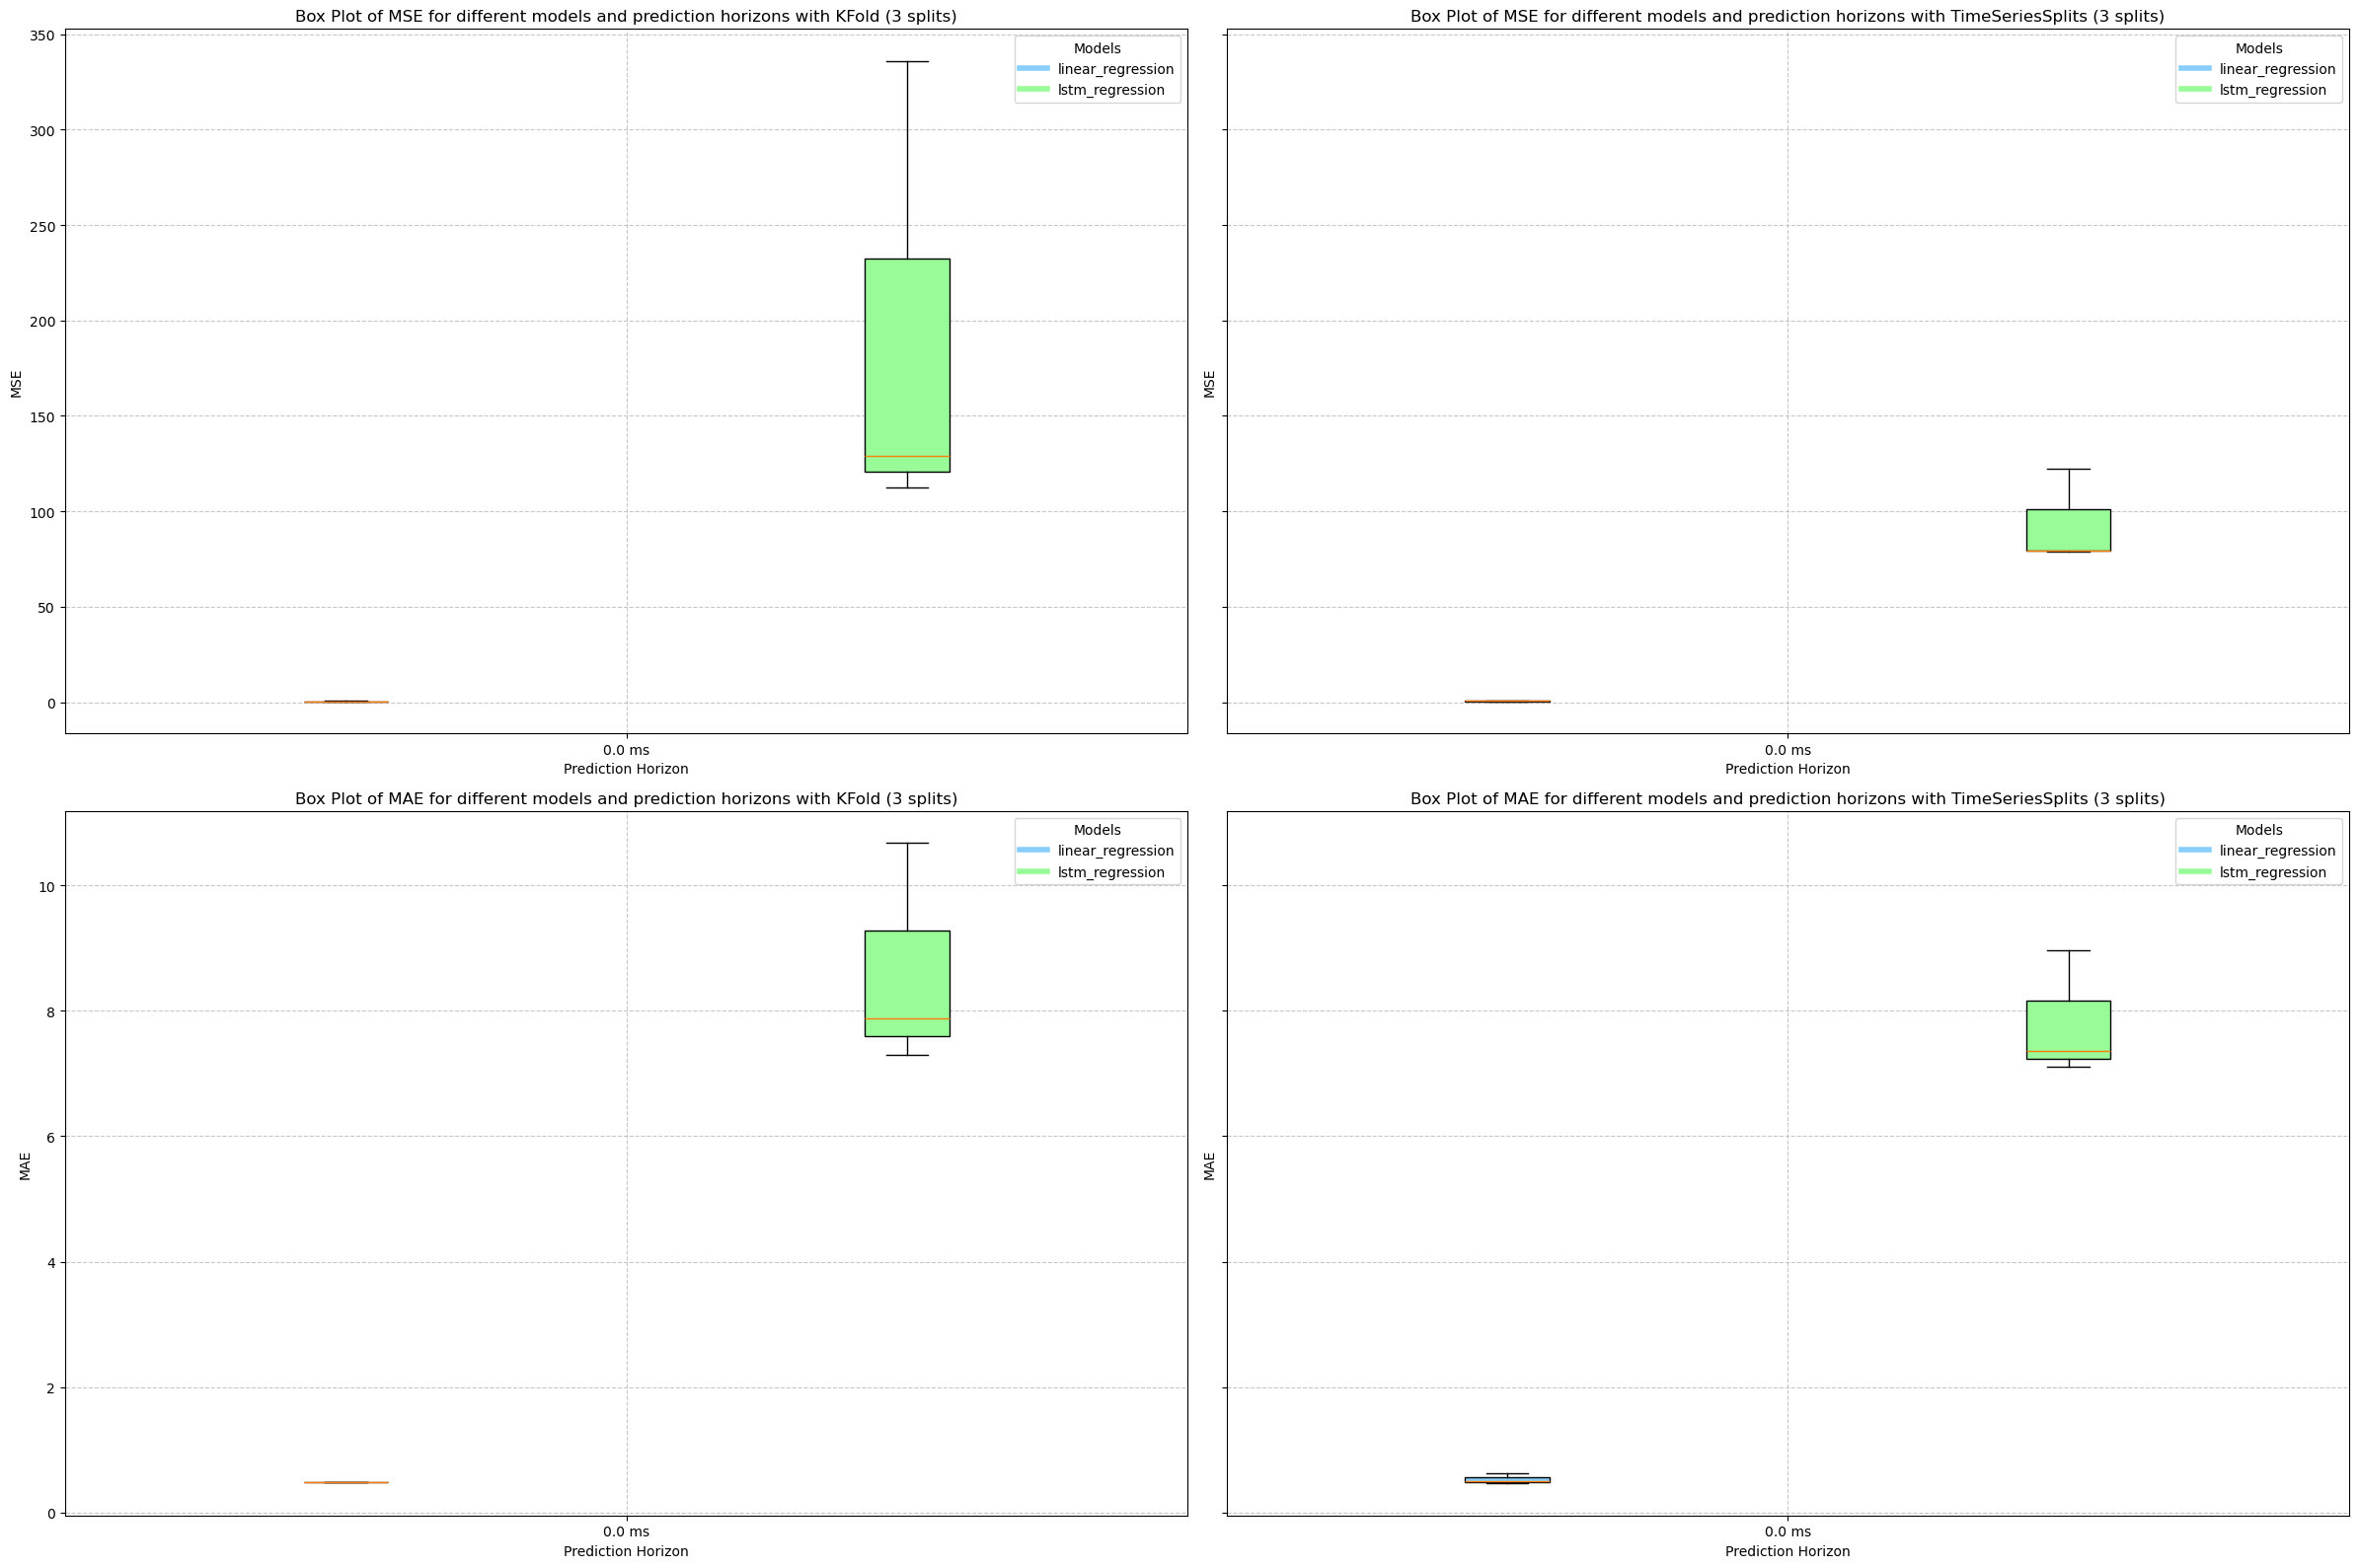

In [ ]:
n_splits=3

# Prepare data for box plot (MSE and MAE)
box_data_kf_mse = []
box_data_tscv_mse = []
box_data_kf_mae = []
box_data_tscv_mae = []

labels = []
colors = ['#87CEFA', '#98FB98', '#FFB6C1', '#FFD700'] # colors for each model
positions_kf_mse = []
positions_tscv_mse = []
positions_kf_mae = []
positions_tscv_mae = []

# Adjust the positions of the boxplots
for i, (horizon_ms, horizon_samples) in enumerate(zip(horizons_ms, horizons_samples)):
    for j, model in enumerate(models):
        # Prepare data for KFold and TimeSeriesSplit (MSE and MAE)
        mse_kf = [predictions_kf[horizon_samples][model][fold]['mse'] for fold in range(1, n_splits + 1)]
        box_data_kf_mse.append(mse_kf)
        positions_kf_mse.append(i * (len(models) + 1) + j)

        mae_kf = [predictions_kf[horizon_samples][model][fold]['mae'] for fold in range(1, n_splits + 1)]
        box_data_kf_mae.append(mae_kf)
        positions_kf_mae.append(i * (len(models) + 1) + j)

        mse_tscv = [predictions_tscv[horizon_samples][model][fold]['mse'] for fold in range(1, n_splits + 1)]
        box_data_tscv_mse.append(mse_tscv)
        positions_tscv_mse.append(i * (len(models) + 1) + j)

        mae_tscv = [predictions_tscv[horizon_samples][model][fold]['mae'] for fold in range(1, n_splits + 1)]
        box_data_tscv_mae.append(mae_tscv)
        positions_tscv_mae.append(i * (len(models) + 1) + j)

        labels.append(f"{horizon_ms} ms")

# Create figure and subplots for KFold and TimeSeriesSplit
fig, axs = plt.subplots(2, 2, figsize=(24, 16), sharey='row')

# Create box plot for KFold MSE
box_kf_mse = axs[0, 0].boxplot(box_data_kf_mse, positions=positions_kf_mse, patch_artist=True)
axs[0, 0].set_title(f'Box Plot of MSE for different models and prediction horizons with KFold ({n_splits} splits)')
axs[0, 0].set_xlabel('Prediction Horizon')
axs[0, 0].set_ylabel('MSE')
axs[0, 0].grid(True, linestyle='--', alpha=0.7)

# Create box plot for TimeSeriesSplit MSE
box_tscv_mse = axs[0, 1].boxplot(box_data_tscv_mse, positions=positions_tscv_mse, patch_artist=True)
axs[0, 1].set_title(f'Box Plot of MSE for different models and prediction horizons with TimeSeriesSplits ({n_splits} splits)')
axs[0, 1].set_xlabel('Prediction Horizon')
axs[0, 1].set_ylabel('MSE')
axs[0, 1].grid(True, linestyle='--', alpha=0.7)

# Create box plot for KFold MAE
box_kf_mae = axs[1, 0].boxplot(box_data_kf_mae, positions=positions_kf_mae, patch_artist=True)
axs[1, 0].set_title(f'Box Plot of MAE for different models and prediction horizons with KFold ({n_splits} splits)')
axs[1, 0].set_xlabel('Prediction Horizon')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].grid(True, linestyle='--', alpha=0.7)

# Create box plot for TimeSeriesSplit MAE
box_tscv_mae = axs[1, 1].boxplot(box_data_tscv_mae, positions=positions_tscv_mae, patch_artist=True)
axs[1, 1].set_title(f'Box Plot of MAE for different models and prediction horizons with TimeSeriesSplits ({n_splits} splits)')
axs[1, 1].set_xlabel('Prediction Horizon')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].grid(True, linestyle='--', alpha=0.7)

# Color the boxes
for patch, color in zip(box_kf_mse['boxes'], colors * len(horizons_samples)):
    patch.set_facecolor(color)
for patch, color in zip(box_tscv_mse['boxes'], colors * len(horizons_samples)):
    patch.set_facecolor(color)

for patch, color in zip(box_kf_mae['boxes'], colors * len(horizons_samples)):
    patch.set_facecolor(color)
for patch, color in zip(box_tscv_mae['boxes'], colors * len(horizons_samples)):
    patch.set_facecolor(color)

# Set x-axis ticks and labels for KFold and TimeSeriesSplit
unique_labels = [f"{horizon_ms} ms" for horizon_ms in horizons_ms]
axs[0, 0].set_xticks(ticks=[i * (len(models) + 1) + (len(models) - 1) / 2 for i in range(len(horizons_ms))])
axs[0, 0].set_xticklabels(unique_labels)
axs[0, 1].set_xticks(ticks=[i * (len(models) + 1) + (len(models) - 1) / 2 for i in range(len(horizons_ms))])
axs[0, 1].set_xticklabels(unique_labels)
axs[1, 0].set_xticks(ticks=[i * (len(models) + 1) + (len(models) - 1) / 2 for i in range(len(horizons_ms))])
axs[1, 0].set_xticklabels(unique_labels)
axs[1, 1].set_xticks(ticks=[i * (len(models) + 1) + (len(models) - 1) / 2 for i in range(len(horizons_ms))])
axs[1, 1].set_xticklabels(unique_labels)

# Annotate outliers with fold index for KFold MSE
for i, (horizon_ms, horizon_samples) in enumerate(zip(horizons_ms, horizons_samples)):
    for j, model in enumerate(models):
        fold_mse_kf = [predictions_kf[horizon_samples][model][fold]['mse'] for fold in range(1, n_splits + 1)]
        for k, mse in enumerate(fold_mse_kf):
            if mse in box_kf_mse['fliers'][i * len(models) + j].get_ydata():
                axs[0, 0].annotate(f'Fold {k+1}', xy=(positions_kf_mse[i * len(models) + j], mse), xytext=(5, 5),
                                   textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

# Annotate outliers with fold index for TimeSeriesSplit MSE
for i, (horizon_ms, horizon_samples) in enumerate(zip(horizons_ms, horizons_samples)):
    for j, model in enumerate(models):
        fold_mse_tscv = [predictions_tscv[horizon_samples][model][fold]['mse'] for fold in range(1, n_splits + 1)]
        for k, mse in enumerate(fold_mse_tscv):
            if mse in box_tscv_mse['fliers'][i * len(models) + j].get_ydata():
                axs[0, 1].annotate(f'Fold {k+1}', xy=(positions_tscv_mse[i * len(models) + j], mse), xytext=(5, 5),
                                   textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

# Annotate outliers with fold index for KFold MAE
for i, (horizon_ms, horizon_samples) in enumerate(zip(horizons_ms, horizons_samples)):
    for j, model in enumerate(models):
        fold_mae_kf = [predictions_kf[horizon_samples][model][fold]['mae'] for fold in range(1, n_splits + 1)]
        for k, mae in enumerate(fold_mae_kf):
            if mae in box_kf_mae['fliers'][i * len(models) + j].get_ydata():
                axs[1, 0].annotate(f'Fold {k+1}', xy=(positions_kf_mae[i * len(models) + j], mae), xytext=(5, 5),
                                   textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

# Annotate outliers with fold index for TimeSeriesSplit MAE
for i, (horizon_ms, horizon_samples) in enumerate(zip(horizons_ms, horizons_samples)):
    for j, model in enumerate(models):
        fold_mae_tscv = [predictions_tscv[horizon_samples][model][fold]['mae'] for fold in range(1, n_splits + 1)]
        for k, mae in enumerate(fold_mae_tscv):
            if mae in box_tscv_mae['fliers'][i * len(models) + j].get_ydata():
                axs[1, 1].annotate(f'Fold {k+1}', xy=(positions_tscv_mae[i * len(models) + j], mae), xytext=(5, 5),
                                   textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
axs[0, 0].legend(handles, models, title="Models")
axs[0, 1].legend(handles, models, title="Models")
axs[1, 0].legend(handles, models, title="Models")
axs[1, 1].legend(handles, models, title="Models")

plt.tight_layout()
plt.show()

In [49]:
# Remove LSTM model from the dictionary of models
linear_models = {name: model for name, model in models.items() if name != 'lstm_regression'} 

# Prepare data for box plot (MSE and MAE)
box_data_kf_mse = []
box_data_tscv_mse = []
box_data_kf_mae = []
box_data_tscv_mae = []

labels = []
colors = ['#87CEFA', '#98FB98', '#FFB6C1'] # colors for each model
positions_kf_mse = []
positions_tscv_mse = []
positions_kf_mae = []
positions_tscv_mae = []

# Adjust the positions of the boxplots
for i, (horizon_ms, horizon_samples) in enumerate(zip(horizons_ms, horizons_samples)):
    for j, model in enumerate(linear_models):
        # Prepare data for KFold and TimeSeriesSplit (MSE and MAE)
        mse_kf = [predictions_kf[horizon_samples][model][fold]['mse'] for fold in range(1, n_splits + 1)]
        box_data_kf_mse.append(mse_kf)
        positions_kf_mse.append(i * (len(linear_models) + 1) + j)

        mae_kf = [predictions_kf[horizon_samples][model][fold]['mae'] for fold in range(1, n_splits + 1)]
        box_data_kf_mae.append(mae_kf)
        positions_kf_mae.append(i * (len(linear_models) + 1) + j)

        mse_tscv = [predictions_tscv[horizon_samples][model][fold]['mse'] for fold in range(1, n_splits + 1)]
        box_data_tscv_mse.append(mse_tscv)
        positions_tscv_mse.append(i * (len(linear_models) + 1) + j)

        mae_tscv = [predictions_tscv[horizon_samples][model][fold]['mae'] for fold in range(1, n_splits + 1)]
        box_data_tscv_mae.append(mae_tscv)
        positions_tscv_mae.append(i * (len(linear_models) + 1) + j)

        labels.append(f"{horizon_ms} ms")

# Create figure and subplots for KFold and TimeSeriesSplit
fig, axs = plt.subplots(2, 2, figsize=(24, 16), sharey='row')

# Create box plot for KFold MSE
box_kf_mse = axs[0, 0].boxplot(box_data_kf_mse, positions=positions_kf_mse, patch_artist=True)
axs[0, 0].set_title(f'Box Plot of MSE for different linear models and prediction horizons with KFold ({n_splits} splits)')
axs[0, 0].set_xlabel('Prediction Horizon')
axs[0, 0].set_ylabel('MSE')
axs[0, 0].grid(True, linestyle='--', alpha=0.7)

# Create box plot for TimeSeriesSplit MSE
box_tscv_mse = axs[0, 1].boxplot(box_data_tscv_mse, positions=positions_tscv_mse, patch_artist=True)
axs[0, 1].set_title(f'Box Plot of MSE for different linear models and prediction horizons with TimeSeriesSplits ({n_splits} splits)')
axs[0, 1].set_xlabel('Prediction Horizon')
axs[0, 1].set_ylabel('MSE')
axs[0, 1].grid(True, linestyle='--', alpha=0.7)

# Create box plot for KFold MAE
box_kf_mae = axs[1, 0].boxplot(box_data_kf_mae, positions=positions_kf_mae, patch_artist=True)
axs[1, 0].set_title(f'Box Plot of MAE for different linear models and prediction horizons with KFold ({n_splits} splits)')
axs[1, 0].set_xlabel('Prediction Horizon')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].grid(True, linestyle='--', alpha=0.7)

# Create box plot for TimeSeriesSplit MAE
box_tscv_mae = axs[1, 1].boxplot(box_data_tscv_mae, positions=positions_tscv_mae, patch_artist=True)
axs[1, 1].set_title(f'Box Plot of MAE for different linear models and prediction horizons with TimeSeriesSplits ({n_splits} splits)')
axs[1, 1].set_xlabel('Prediction Horizon')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].grid(True, linestyle='--', alpha=0.7)

# Color the boxes
for patch, color in zip(box_kf_mse['boxes'], colors * len(horizons_samples)):
    patch.set_facecolor(color)
for patch, color in zip(box_tscv_mse['boxes'], colors * len(horizons_samples)):
    patch.set_facecolor(color)

for patch, color in zip(box_kf_mae['boxes'], colors * len(horizons_samples)):
    patch.set_facecolor(color)
for patch, color in zip(box_tscv_mae['boxes'], colors * len(horizons_samples)):
    patch.set_facecolor(color)

# Set x-axis ticks and labels for KFold and TimeSeriesSplit
unique_labels = [f"{horizon_ms} ms" for horizon_ms in horizons_ms]
axs[0, 0].set_xticks(ticks=[i * (len(linear_models) + 1) + (len(linear_models) - 1) / 2 for i in range(len(horizons_ms))])
axs[0, 0].set_xticklabels(unique_labels)
axs[0, 1].set_xticks(ticks=[i * (len(linear_models) + 1) + (len(linear_models) - 1) / 2 for i in range(len(horizons_ms))])
axs[0, 1].set_xticklabels(unique_labels)
axs[1, 0].set_xticks(ticks=[i * (len(linear_models) + 1) + (len(linear_models) - 1) / 2 for i in range(len(horizons_ms))])
axs[1, 0].set_xticklabels(unique_labels)
axs[1, 1].set_xticks(ticks=[i * (len(linear_models) + 1) + (len(linear_models) - 1) / 2 for i in range(len(horizons_ms))])
axs[1, 1].set_xticklabels(unique_labels)

# Annotate outliers with fold index for KFold MSE
for i, (horizon_ms, horizon_samples) in enumerate(zip(horizons_ms, horizons_samples)):
    for j, model in enumerate(linear_models):
        fold_mse_kf = [predictions_kf[horizon_samples][model][fold]['mse'] for fold in range(1, n_splits + 1)]
        for k, mse in enumerate(fold_mse_kf):
            if mse in box_kf_mse['fliers'][i * len(linear_models) + j].get_ydata():
                axs[0, 0].annotate(f'Fold {k+1}', xy=(positions_kf_mse[i * len(linear_models) + j], mse), xytext=(5, 5),
                                   textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

# Annotate outliers with fold index for TimeSeriesSplit MSE
for i, (horizon_ms, horizon_samples) in enumerate(zip(horizons_ms, horizons_samples)):
    for j, model in enumerate(linear_models):
        fold_mse_tscv = [predictions_tscv[horizon_samples][model][fold]['mse'] for fold in range(1, n_splits + 1)]
        for k, mse in enumerate(fold_mse_tscv):
            if mse in box_tscv_mse['fliers'][i * len(linear_models) + j].get_ydata():
                axs[0, 1].annotate(f'Fold {k+1}', xy=(positions_tscv_mse[i * len(linear_models) + j], mse), xytext=(5, 5),
                                   textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

# Annotate outliers with fold index for KFold MAE
for i, (horizon_ms, horizon_samples) in enumerate(zip(horizons_ms, horizons_samples)):
    for j, model in enumerate(linear_models):
        fold_mae_kf = [predictions_kf[horizon_samples][model][fold]['mae'] for fold in range(1, n_splits + 1)]
        for k, mae in enumerate(fold_mae_kf):
            if mae in box_kf_mae['fliers'][i * len(linear_models) + j].get_ydata():
                axs[1, 0].annotate(f'Fold {k+1}', xy=(positions_kf_mae[i * len(linear_models) + j], mae), xytext=(5, 5),
                                   textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

# Annotate outliers with fold index for TimeSeriesSplit MAE
for i, (horizon_ms, horizon_samples) in enumerate(zip(horizons_ms, horizons_samples)):
    for j, model in enumerate(linear_models):
        fold_mae_tscv = [predictions_tscv[horizon_samples][model][fold]['mae'] for fold in range(1, n_splits + 1)]
        for k, mae in enumerate(fold_mae_tscv):
            if mae in box_tscv_mae['fliers'][i * len(linear_models) + j].get_ydata():
                axs[1, 1].annotate(f'Fold {k+1}', xy=(positions_tscv_mae[i * len(linear_models) + j], mae), xytext=(5, 5),
                                   textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
axs[0, 0].legend(handles, models, title="Models")
axs[0, 1].legend(handles, models, title="Models")
axs[1, 0].legend(handles, models, title="Models")
axs[1, 1].legend(handles, models, title="Models")

plt.tight_layout()
plt.show()

KeyError: 'mse'

In [ ]:
# # Bar plot for average MSE
# fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
# bar_width = 0.2
# index = np.arange(len(horizons_ms))

# # KFold subplot
# for i, model in enumerate(models):
#     axs[0].bar(index + i * bar_width, [folds_avg_mse_kf[time_horizon][model] for time_horizon in horizons_samples], bar_width, label=model)

# axs[0].set_xlabel('Prediction Horizon (ms)')
# axs[0].set_ylabel('Average MSE')
# axs[0].set_title('Average MSE for Different Models and Prediction Horizons (KFold)')
# axs[0].set_xticks(index + bar_width)
# axs[0].set_xticklabels([f'{ms} ms' for ms in horizons_ms])
# axs[0].legend()
# axs[0].grid(axis='y')

# # TimeSeriesSplit subplot
# for i, model in enumerate(models):
#     axs[1].bar(index + i * bar_width, [folds_avg_mse_tscv[time_horizon][model] for time_horizon in horizons_samples], bar_width, label=model)

# axs[1].set_xlabel('Prediction Horizon (ms)')
# axs[1].set_title('Average MSE for Different Models and Prediction Horizons (TimeSeriesSplit)')
# axs[1].set_xticks(index + bar_width)
# axs[1].set_xticklabels([f'{ms} ms' for ms in horizons_ms])
# axs[1].legend()
# axs[1].grid(axis='y')

# plt.tight_layout()
# plt.show()


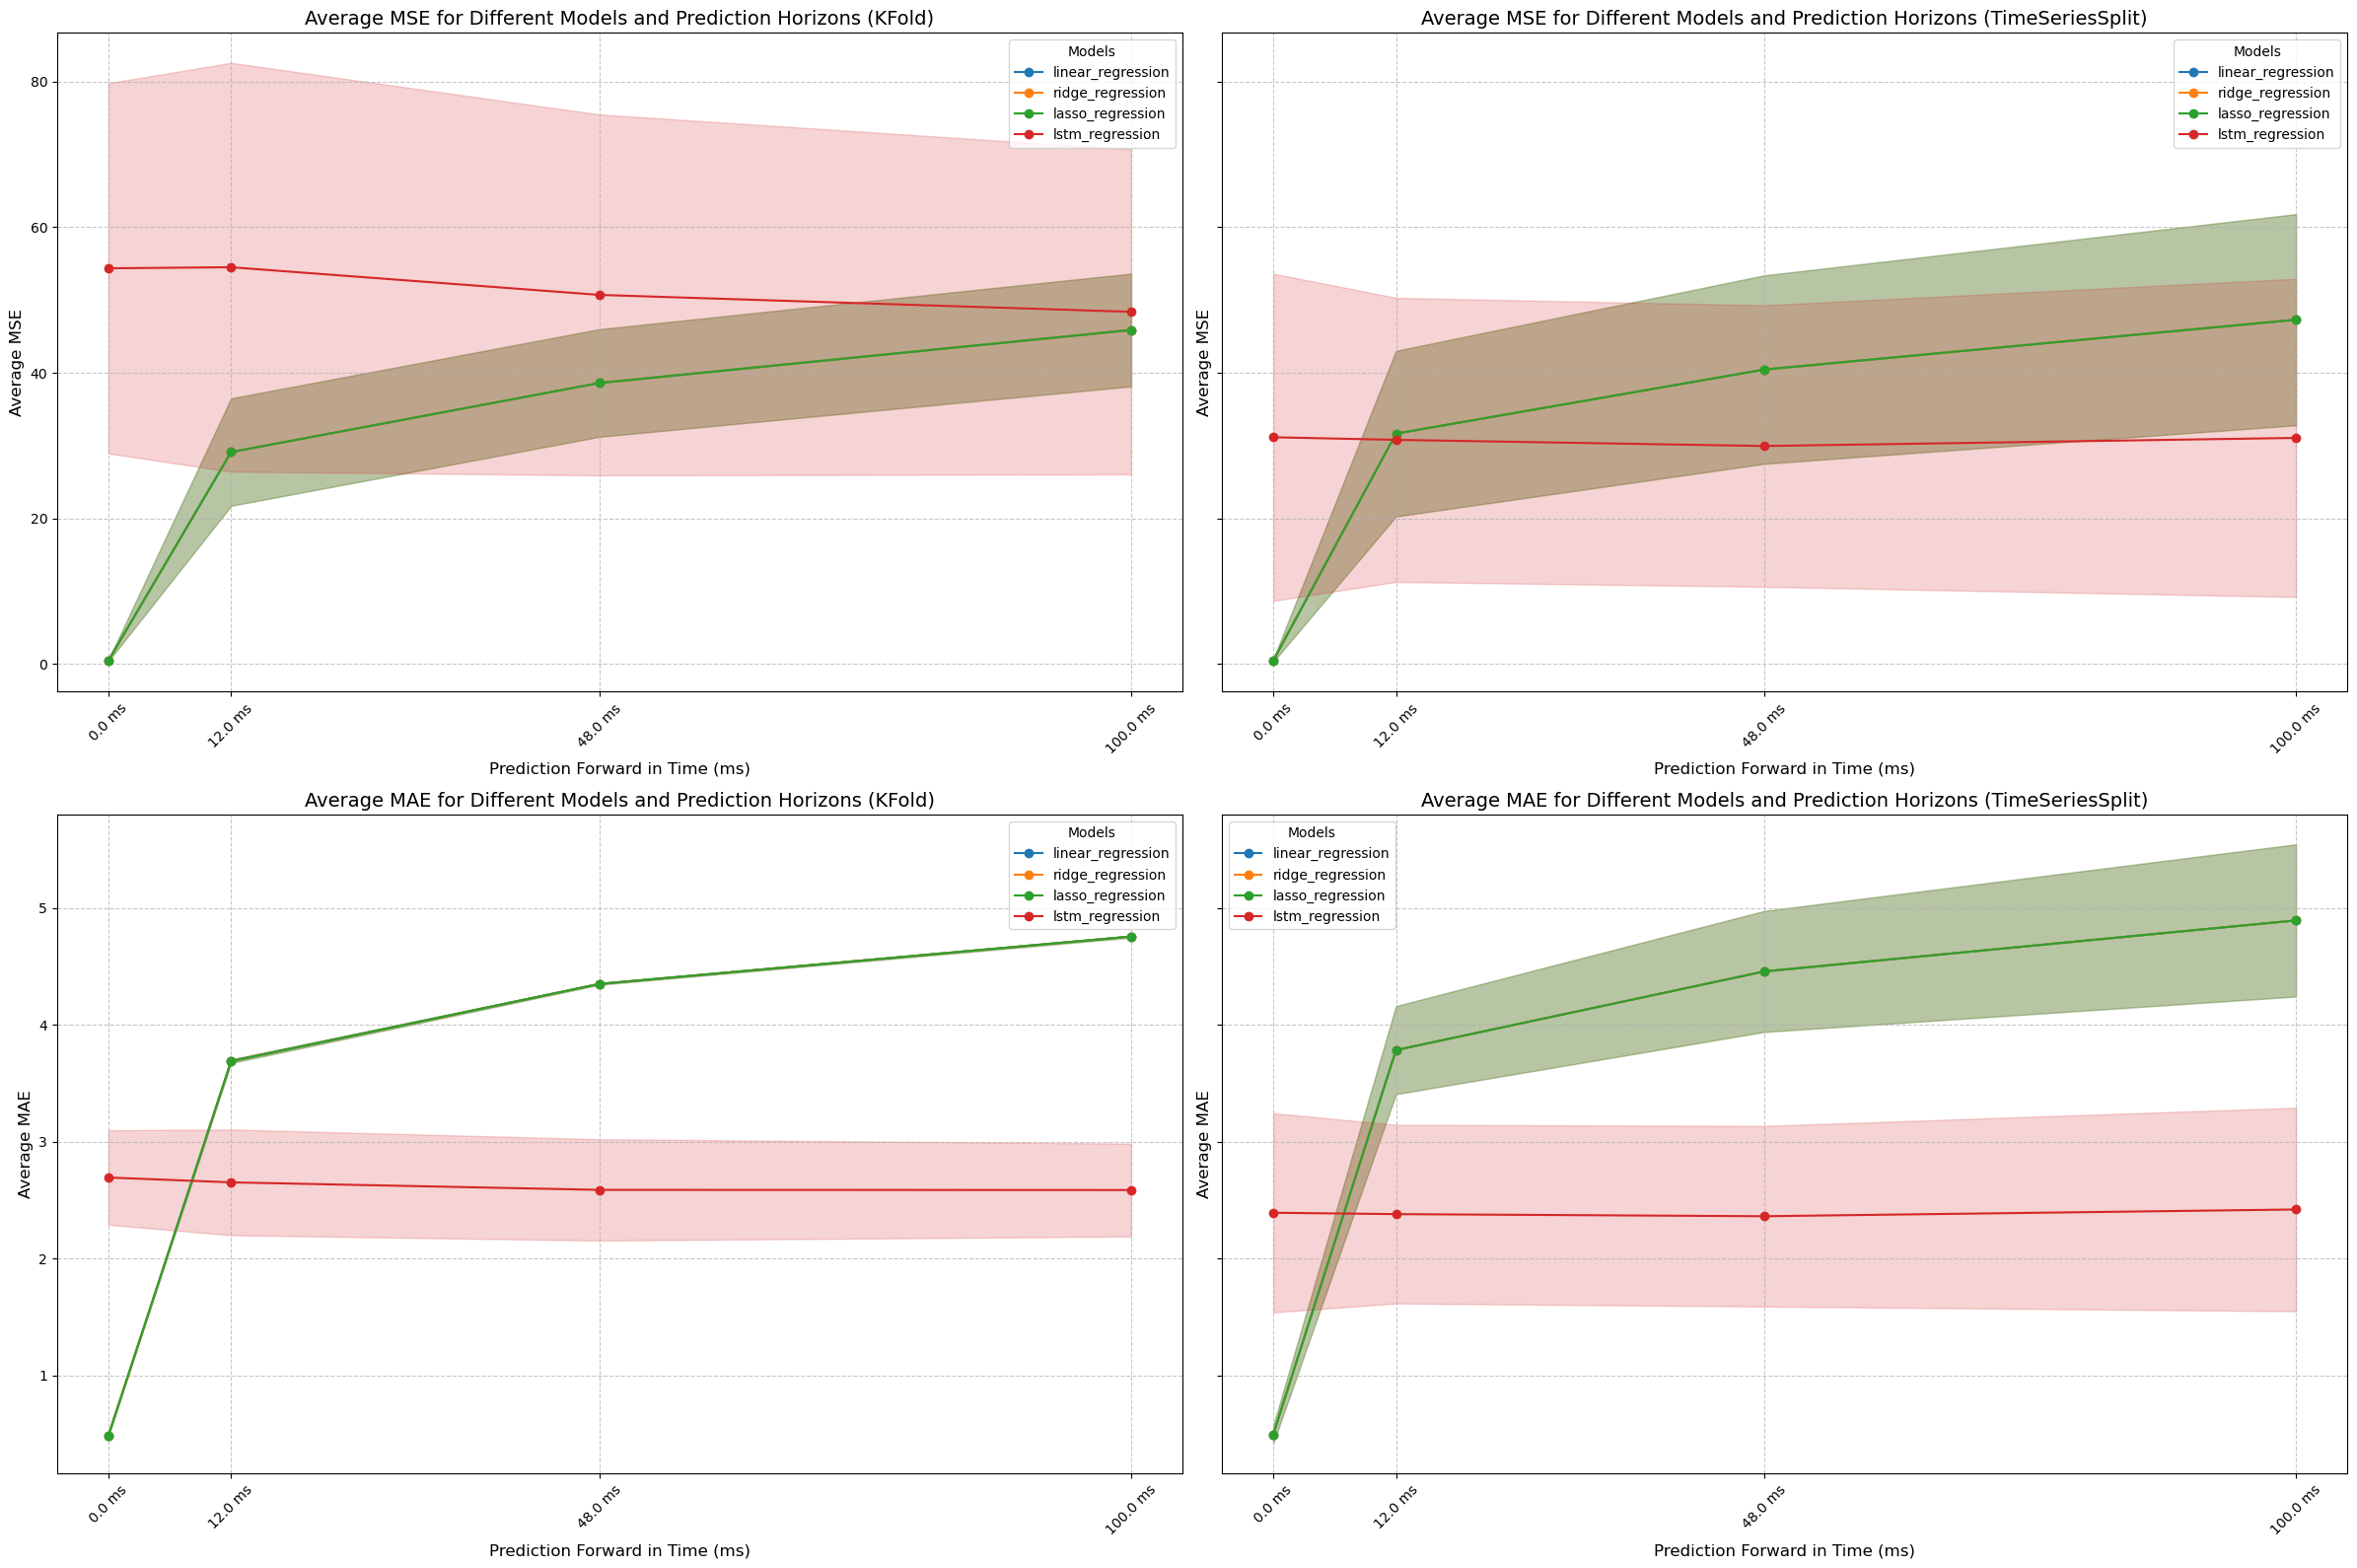

In [ ]:
# Define colors for models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Adjust as needed

# Line plot for average metrics with variance
fig, axs = plt.subplots(2, 2, figsize=(24, 16), sharey='row')  # 2 rows, 2 columns for MSE and MAE

# Function to plot metrics for a specific axis
def plot_metrics(ax, horizons, folds_avg_metrics, metric, title):
    for idx, model in enumerate(models):
        # Prepare average and standard deviation for the given metric
        mean_metric = [folds_avg_metrics[horizon][model][metric]['avg'] for horizon in horizons]
        std_metric = [folds_avg_metrics[horizon][model][metric]['std'] for horizon in horizons]

        # Plot line and fill variance
        ax.plot(horizons_ms, mean_metric, marker='o', label=model, color=colors[idx])
        ax.fill_between(horizons_ms, 
                        np.array(mean_metric) - np.array(std_metric), 
                        np.array(mean_metric) + np.array(std_metric), 
                        color=colors[idx], alpha=0.2)

    # Customize the subplot
    ax.set_xlabel('Prediction Forward in Time (ms)', fontsize=12)
    ax.set_ylabel(f'Average {metric.upper()}', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(title="Models", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

# Plot MSE for KFold
plot_metrics(axs[0, 0], horizons_samples, folds_avg_metrics_kf, 'mse', 
             'Average MSE for Different Models and Prediction Horizons (KFold)')

# Plot MSE for TimeSeriesSplit
plot_metrics(axs[0, 1], horizons_samples, folds_avg_metrics_tscv, 'mse', 
             'Average MSE for Different Models and Prediction Horizons (TimeSeriesSplit)')

# Plot MAE for KFold
plot_metrics(axs[1, 0], horizons_samples, folds_avg_metrics_kf, 'mae', 
             'Average MAE for Different Models and Prediction Horizons (KFold)')

# Plot MAE for TimeSeriesSplit
plot_metrics(axs[1, 1], horizons_samples, folds_avg_metrics_tscv, 'mae', 
             'Average MAE for Different Models and Prediction Horizons (TimeSeriesSplit)')

# Set x-axis ticks and labels for all subplots
for ax in axs.flat:
    ax.set_xticks(horizons_ms)
    ax.set_xticklabels([f'{ms} ms' for ms in horizons_ms], rotation=45)

plt.tight_layout()
plt.show()

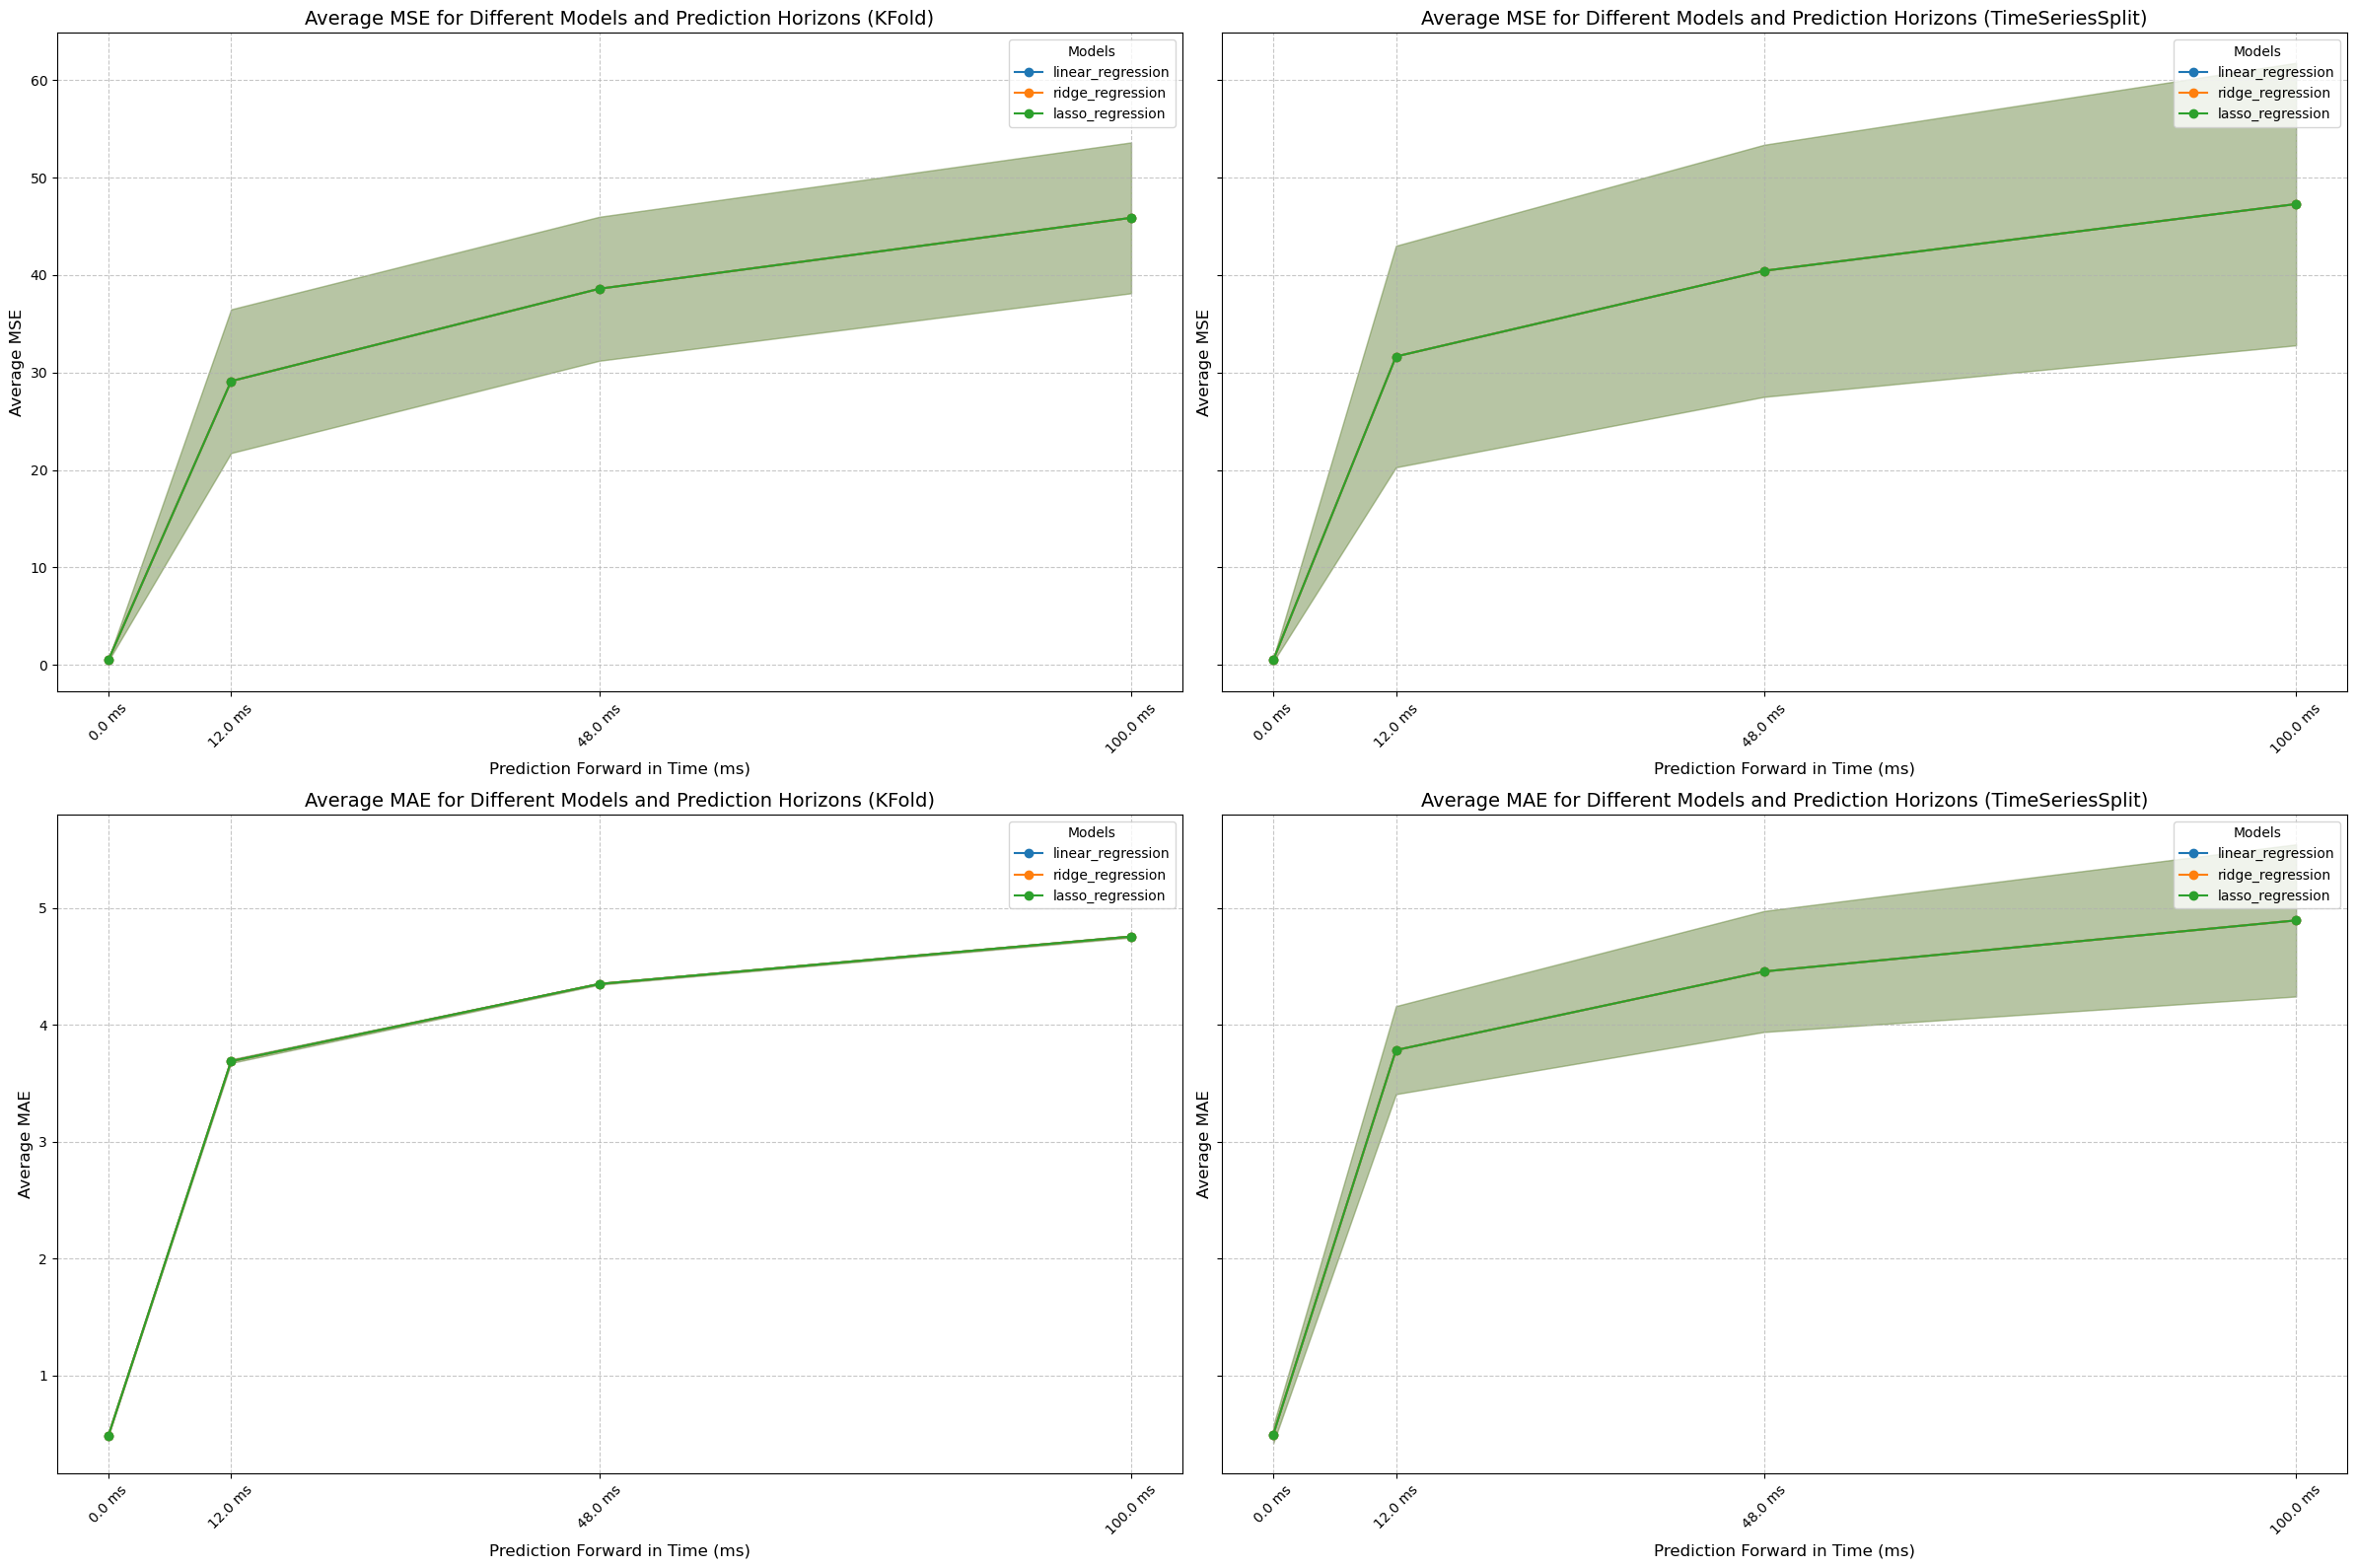

In [ ]:
# Define colors for models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Adjust as needed

# Line plot for average metrics with variance
fig, axs = plt.subplots(2, 2, figsize=(24, 16), sharey='row')  # 2 rows, 2 columns for MSE and MAE

# Function to plot metrics for a specific axis
def plot_metrics(ax, horizons, folds_avg_metrics, metric, title):
    for idx, model in enumerate(linear_models):
        # Prepare average and standard deviation for the given metric
        mean_metric = [folds_avg_metrics[horizon][model][metric]['avg'] for horizon in horizons]
        std_metric = [folds_avg_metrics[horizon][model][metric]['std'] for horizon in horizons]

        # Plot line and fill variance
        ax.plot(horizons_ms, mean_metric, marker='o', label=model, color=colors[idx])
        ax.fill_between(horizons_ms, 
                        np.array(mean_metric) - np.array(std_metric), 
                        np.array(mean_metric) + np.array(std_metric), 
                        color=colors[idx], alpha=0.2)

    # Customize the subplot
    ax.set_xlabel('Prediction Forward in Time (ms)', fontsize=12)
    ax.set_ylabel(f'Average {metric.upper()}', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(title="Models", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

# Plot MSE for KFold
plot_metrics(axs[0, 0], horizons_samples, folds_avg_metrics_kf, 'mse', 
             'Average MSE for Different Models and Prediction Horizons (KFold)')

# Plot MSE for TimeSeriesSplit
plot_metrics(axs[0, 1], horizons_samples, folds_avg_metrics_tscv, 'mse', 
             'Average MSE for Different Models and Prediction Horizons (TimeSeriesSplit)')

# Plot MAE for KFold
plot_metrics(axs[1, 0], horizons_samples, folds_avg_metrics_kf, 'mae', 
             'Average MAE for Different Models and Prediction Horizons (KFold)')

# Plot MAE for TimeSeriesSplit
plot_metrics(axs[1, 1], horizons_samples, folds_avg_metrics_tscv, 'mae', 
             'Average MAE for Different Models and Prediction Horizons (TimeSeriesSplit)')

# Set x-axis ticks and labels for all subplots
for ax in axs.flat:
    ax.set_xticks(horizons_ms)
    ax.set_xticklabels([f'{ms} ms' for ms in horizons_ms], rotation=45)

plt.tight_layout()
plt.show()

(42.013012, 42.01301063029869)

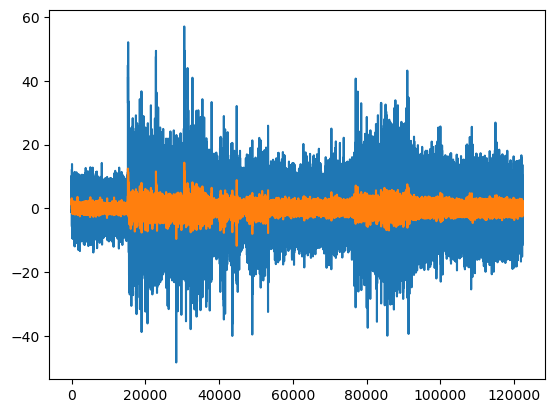

In [ ]:
t = predictions_kf[horizons_samples[3]]['linear_regression'][5]['y_test']
p = predictions_kf[horizons_samples[3]]['linear_regression'][5]['y_pred']

plt.plot(t.reshape(-1, t.shape[-1])[:, 3], label='True')
plt.plot(p.reshape(-1, p.shape[-1])[:, 3], label='True')

from tensorflow.keras.metrics import MeanSquaredError

m = MeanSquaredError()
m.update_state(t, p)
m.result().numpy(), np.square(t - p).mean()

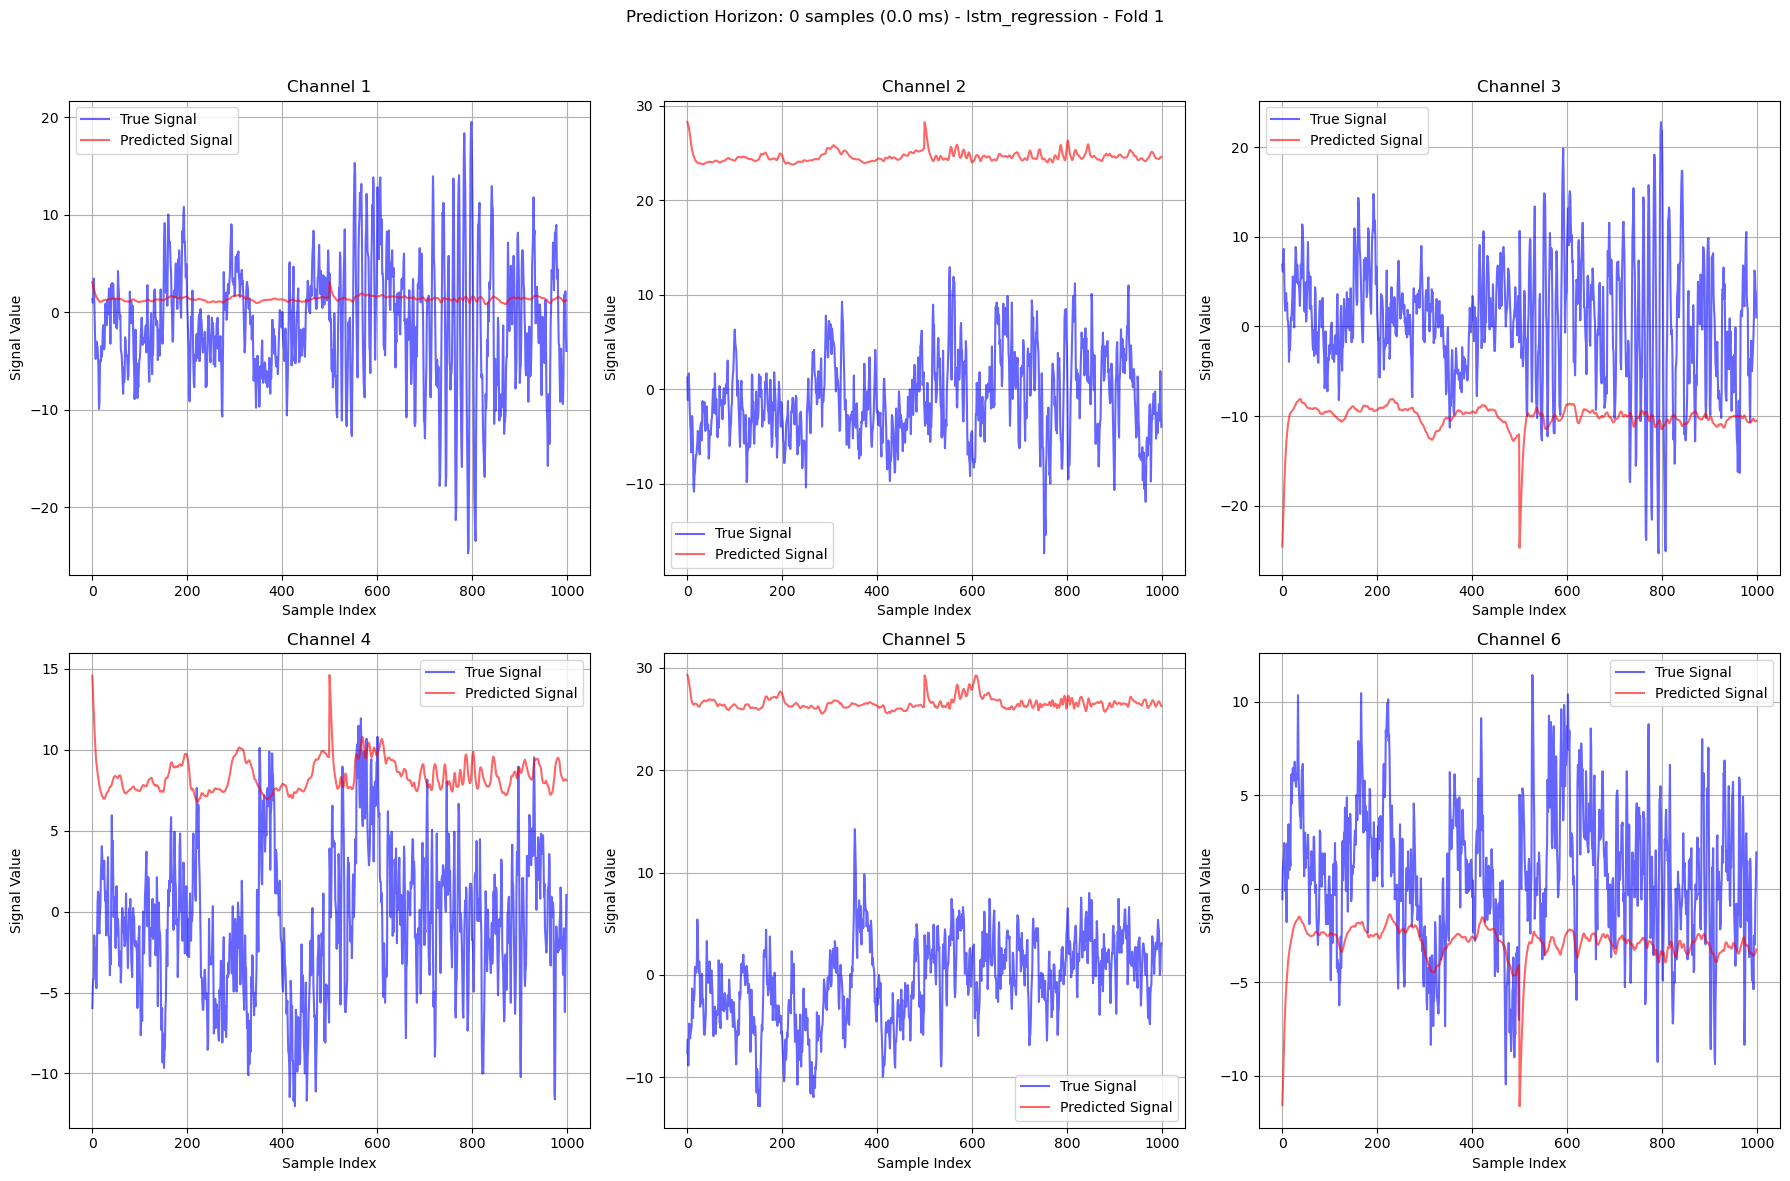

In [ ]:
def visualize_best_model_predictions(predictions, horizon, model_name, fold, sfreq, num_samples=100):
    """
    Visualize the predictions of the best model for a given model name and horizon.
    
    Parameters:
    - predictions: Dictionary containing all predictions for each model
    - model_name: Name of the model to visualize
    - horizon: Horizon value to visualize
    - sfreq: Sampling frequency
    - num_samples: Number of samples to visualize
    """

    y_test = predictions[horizon][model_name][fold]['y_test'] 
    y_pred = predictions[horizon][model_name][fold]['y_pred']
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows and 3 columns for 6channels
    fig.suptitle(f'Prediction Horizon: {horizon} samples ({horizon / sfreq * 1000} ms) - {model_name} - Fold {fold}')

    if model_name == 'lstm_regression' or (y_test.ndim == 3 and y_test.ndim == 3):
        y_test = y_test.reshape(-1, y_test.shape[-1])
        y_pred = y_pred.reshape(-1, y_pred.shape[-1])
        
    for ch in range(y_test.shape[1]):
        row = ch // 3
        col = ch % 3
        axs[row, col].plot(y_test[:num_samples, ch], label='True Signal', color='blue', alpha=0.6)
        axs[row, col].plot(y_pred[:num_samples, ch], label='Predicted Signal', color='red', alpha=0.6)
        axs[row, col].set_xlabel('Sample Index')
        axs[row, col].set_ylabel('Signal Value')
        axs[row, col].set_title(f'Channel {ch + 1}')
        axs[row, col].legend()
        axs[row, col].grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

visualize_best_model_predictions(
    predictions=predictions_tscv,
    horizon=horizons_samples[0],
    model_name="lstm_regression",
    fold=1,
    sfreq=sfreq,
    num_samples=1000000
)


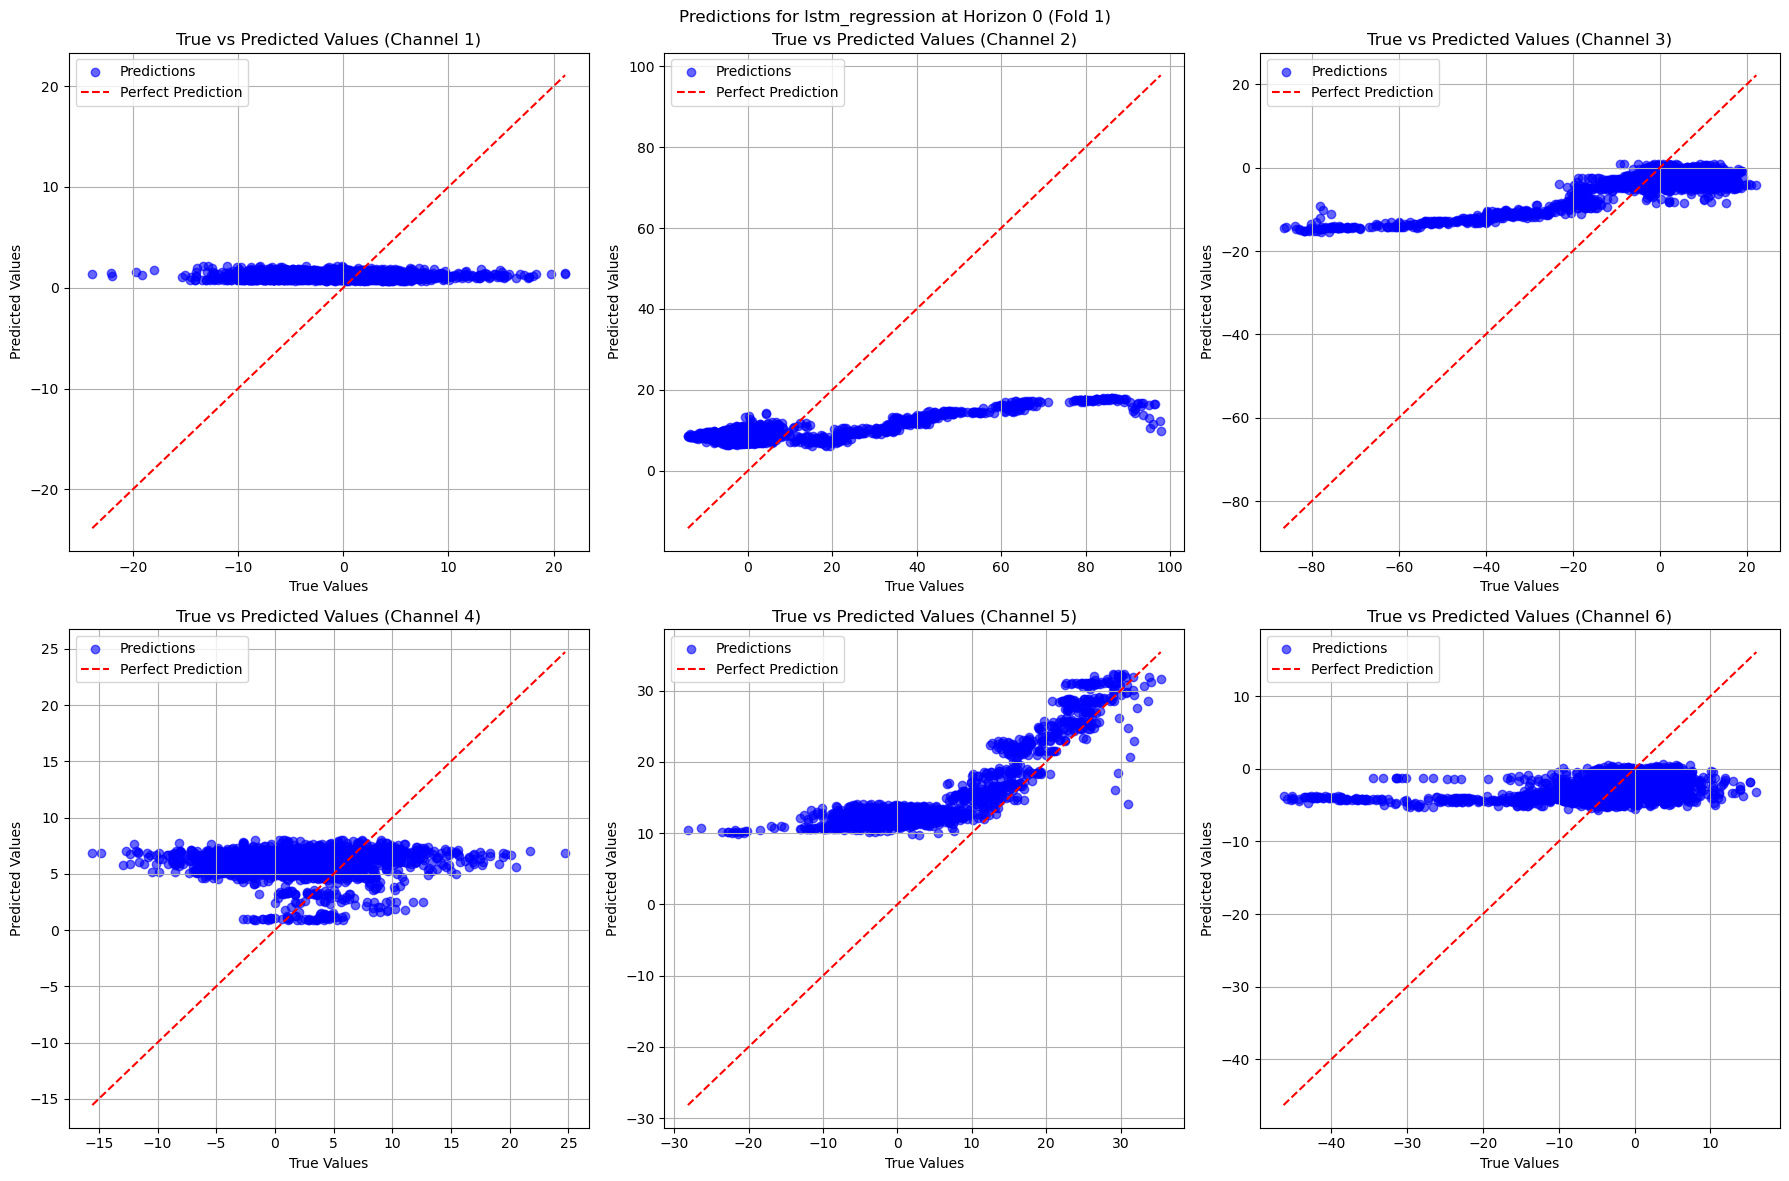

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(predictions, horizon, model_name, fold, num_samples=100):
    """
    Visualize predictions by plotting predicted vs. true values.
    
    Parameters:
    - predictions: Dictionary containing all predictions for each model
    - horizon: Horizon value to visualize
    - model_name: Name of the model to visualize
    - fold: Fold number to visualize
    - num_samples: Number of samples to visualize
    """
    y_test = predictions[horizon][model_name][fold]['y_test']
    y_pred = predictions[horizon][model_name][fold]['y_pred']
    
    if model_name == 'lstm_regression' or (y_test.ndim == 3 and y_test.ndim == 3):
        y_test = y_test.reshape(-1, y_test.shape[-1])
        y_pred = y_pred.reshape(-1, y_pred.shape[-1])
        
    n_channels = y_test.shape[1]
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows and 3 columns
    
    for ch in range(n_channels):
        row = ch // 3
        col = ch % 3
        axs[row, col].scatter(y_test[:num_samples, ch], y_pred[:num_samples, ch], color='blue', alpha=0.6, label="Predictions")
        axs[row, col].plot([min(y_test[:num_samples, ch]), max(y_test[:num_samples, ch])], [min(y_test[:num_samples, ch]), max(y_test[:num_samples, ch])], color='red', linestyle='--', label="Perfect Prediction")
        axs[row, col].set_xlabel('True Values')
        axs[row, col].set_ylabel('Predicted Values')
        axs[row, col].set_title(f'True vs Predicted Values (Channel {ch + 1})')
        axs[row, col].legend(loc='upper left')
        axs[row, col].grid(True)
    
    fig.suptitle(f'Predictions for {model_name} at Horizon {horizon} (Fold {fold})')
    plt.tight_layout()
    plt.show()

visualize_predictions(predictions_kf,
                      horizon=horizons_samples[0],
                      model_name='lstm_regression',
                      fold=1,
                      num_samples=10000000)

In [ ]:
time_continuous_uniform.shape

(16, 6, 38213)

# LogisticRegression --> from here on moved to classification_experiments/log_reg2.py


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.preprocessing import StandardScaler

def train_logistic_regression_cv(data, labels, n_splits=5, max_iter=2000):
    """
    Trains logistic regression with cross-validation on data with arbitrary shape.
    Data is reshaped and scaled if needed. Returns models trained on each fold.
    """
    # Flatten and scale data
    if data.ndim > 2:
        data = data.reshape(data.shape[0], -1)
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # Initialize the model and cross-validation
    models = []
    indices = []
    kf = StratifiedKFold(n_splits=n_splits)
    
    for train_index, test_index in kf.split(data, labels):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
        model = LogisticRegression(max_iter=max_iter)
        model.fit(X_train, y_train)
        
        models.append(model)
        indices.append((train_index, test_index))
        
    return models, indices


def evaluate_models(models, data, labels, indices):
    """
    Evaluates trained models on specified test data splits, and calculates metrics.

    Parameters:
    - models (list): List of trained models for each fold.
    - data (np.ndarray): The input data, flattened if necessary.
    - labels (np.ndarray): True labels.
    - indices (list): List of (train_index, test_index) tuples for each fold.

    Returns:
    - metrics (dict): Dictionary with metrics.
    """
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }

    # Evaluate each model
    for model, (train_index, test_index) in zip(models, indices):
        X_test = data[test_index]
        y_test = labels[test_index]
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate and store metrics
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred, average='weighted'))
        metrics['recall'].append(recall_score(y_test, y_pred, average='weighted'))
        metrics['f1'].append(f1_score(y_test, y_pred, average='weighted'))
        metrics['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
    
    # Print metrics
    for key, values in metrics.items():
        if key != 'confusion_matrices':
            print(f"{key.capitalize()} - Mean: {np.mean(values):.2f}, Std: {np.std(values):.2f}")
        else:
            for i, cm in enumerate(values):
                print(f"Confusion Matrix for fold {i + 1}:\n{cm}\n")
    
    return metrics


In [ ]:
# Train models with cross-validation

# # The evaluation function remains the same as before
# models, indices = train_logistic_regression_with_cv(combined_psds_bandPower, labels)

# # Evaluate trained models
# metrics = evaluate_models(models, combined_psds_bandPower, labels, indices)



In [ ]:
epochs.get_data().shape

NameError: name 'epochs' is not defined

In [ ]:
logistic_model.evaluate(combined_psds_bandPower2.reshape(combined_psds_bandPower2.shape[0], -1), labels2)


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
import tensorflow.keras.backend as K

# Initialize metrics dictionary
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

# Reshape combined_data for LSTM input
# Reshape into (n_samples, time_steps, n_features)
# Here, we treat the whole feature set as a single time step.
X_reshaped = combined_psds_bandPower.reshape(combined_psds_bandPower.shape[0],
                                             1, 
                                             combined_psds_bandPower.shape[1])

# Generate labels
labels = np.concatenate((np.ones(psds_bandPower_mod_start.shape[0]),
                         np.zeros(psds_bandPower_normal_walking.shape[0])), axis=0)

def create_model(input_shape, learning_rate=0.0005):
    """
    Create and compile an LSTM model with dropout layers and focal loss.
    
    Parameters:
    - input_shape: Tuple representing the shape of the input data.
    
    Returns:
    - model: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer with a reduced learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=focal_loss(gamma=2, alpha=0.25), optimizer=optimizer, metrics=['accuracy'])
    return model

def focal_loss(gamma=2., alpha=0.75):
    """
    Custom focal loss function to handle class imbalance.
    
    Parameters:
    - gamma: Focusing parameter for focal loss.
    - alpha: Balancing factor for classes.
    
    Returns:
    - focal_loss_fixed: Focal loss function
    """
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, dtype='float32')
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl = -alpha_t * K.pow(1. - p_t, gamma) * K.log(p_t + K.epsilon())
        return K.mean(fl)
    return focal_loss_fixed

# Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5)

for train_index, test_index in kf.split(X_reshaped, labels):
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Apply SMOTE for resampling the training data
    X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten for SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)
    X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], 1, X_train.shape[2])  # Reshape back for LSTM

    model = create_model((X_train_resampled.shape[1], X_train_resampled.shape[2]))  # (time_steps, features)
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Train the model
    class_weights = {0: 1.5, 1: 1.0}  # Increase weight for the minority class
    history = model.fit(X_train_resampled, y_train_resampled, 
                        epochs=50, 
                        batch_size=32, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping], 
                        class_weight=class_weights, 
                        verbose=0)

    # Evaluate the model
    y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Threshold at 0.5 for binary classification
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred, zero_division=1))
    metrics['recall'].append(recall_score(y_test, y_pred, zero_division=1))
    metrics['f1'].append(f1_score(y_test, y_pred, zero_division=1))
    metrics['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

# Print results
for key in metrics:
    if key != 'confusion_matrices':
        print(f"{key.capitalize()} - Mean: {np.mean(metrics[key]):.2f}, Std: {np.std(metrics[key]):.2f}")
    else:
        for i, cm in enumerate(metrics['confusion_matrices']):
            print(f"Confusion Matrix for fold {i + 1}:\n{cm}\n")


In [ ]:
np.unique(labels, return_counts=True)[1], np.unique(y_train_resampled, return_counts=True)[1]

# Grid search: hyperparameters
learning rate, dropout rate, and LSTM layer sizes

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Define the model function for grid search
def create_model(lstm_units=32, dropout_rate=0.2, learning_rate=0.001, l2_reg=0.001):
    model = Sequential()
    
    # First LSTM layer with regularization
    model.add(LSTM(lstm_units, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2]),
                   return_sequences=True, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with regularization
    model.add(LSTM(lstm_units // 2, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Dense output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Wrap the model in KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

# Define the parameter grid with more diverse LSTM layer sizes and L2 regularization
param_grid = {
    'lstm_units': [128],          # Different LSTM layer sizes
    'dropout_rate': [0.2],      # Different dropout rates
    'learning_rate': [0.0001],  # Different learning rates
    'l2_reg': [0.001]               # L2 regularization values
}

# Initialize Stratified K-Fold cross-validation
kf = StratifiedKFold(n_splits=5)

# Use F1-score as the scoring metric
scorer = make_scorer(f1_score, average='weighted')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=kf, verbose=2)

# Perform the grid search
grid_result = grid_search.fit(X_reshaped, labels)

# Output the best parameters and best score
print("Best parameters found: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)

# Evaluate with confusion matrix
best_model = grid_result.best_estimator_.model
y_pred = (best_model.predict(X_reshaped) > 0.5).astype("int32")
conf_matrix = confusion_matrix(labels, y_pred)

print("Confusion Matrix:\n", conf_matrix)

In [ ]:
# Best parameters found:  {'dropout_rate': 0.2, 'learning_rate': 0.001, 'lstm_units': 32}
# {'dropout_rate': 0.2, 'l2_reg': 0.001, 'learning_rate': 0.0001, 'lstm_units': 128}
# Best score:  0.7191735711731744

In [ ]:
print("Grid Search Results:")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print(f"Mean: {mean:.4f} (+/- {std:.4f}) with parameters: {param}")

In [ ]:

# Combine modulation start features
print(psds_bandPower_mod_start.shape)

# Combine normal walking features
print(psds_bandPower_normal_walking.shape)

# Combine all samples
print(combined_psds_bandPower.shape)

# Generate labels
# labels = np.concatenate((np.ones(psds_bandPower_mod_start.shape[0]), np.zeros(psds_bandPower_normal_walking.shape[0])), axis=0)

# Alternativly do not flatten across the channels

In [ ]:
psds_bandPower_mod_start = np.concatenate((psds_mod_start,
                                           band_power_mod_start), axis=2)

psds_bandPower_normal_walking = np.concatenate((psds_normal_walking, 
                                                band_power_normal_walking), axis=2)

combined_psds_bandPower = np.concatenate((psds_bandPower_mod_start,
                                          psds_bandPower_normal_walking), axis=0)

# Generate labels
labels = np.concatenate((np.ones(psds_bandPower_mod_start.shape[0]),
                         np.zeros(psds_bandPower_normal_walking.shape[0])), axis=0)



from sklearn.preprocessing import StandardScaler

# Reshape the data for LSTM
X_reshaped = combined_psds_bandPower.reshape((combined_psds_bandPower.shape[0], 
                                               combined_psds_bandPower.shape[1], 
                                               combined_psds_bandPower.shape[2]))

# Check the shape after reshaping
print("X_reshaped shape:", X_reshaped.shape)  # Expected: (757, 6, 123)

# Reshape data to 2D for scaling (samples, features)
X_reshaped_2d = X_reshaped.reshape(-1, X_reshaped.shape[-1])

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped_2d)

# Reshape back to 3D
X_scaled = X_scaled.reshape(X_reshaped.shape)

print("X_scaled shape:", X_scaled.shape)  # Expected: (757, 6, 123)